## Importing the necessary libraries

In [257]:
import numpy as np
import pandas as pd

import spacy
import string 

import matplotlib.pyplot
import seaborn as sns

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix




## Loading English language model

In [258]:
nlp = spacy.load("en_core_web_sm")

## Importing the Dataset

In [259]:
df=pd.read_csv("Active&Passive.csv")

In [260]:
df.head()

,Statements,Labels
0,The dog chased the cat.,active
1,She ate an apple.,active
2,He reads books every day.,active
3,They built a new house.,active
4,The teacher explained the lesson.,active


In [261]:
df.tail()

,Statements,Labels
135,The plans for the house are drawn by the archi...,Passive
136,The work schedule is organized by the manager.,Passive
137,The customers are served efficiently by the wa...,Passive
138,The goods are transported safely by the driver.,Passive
139,The assignment is submitted on time by the stu...,Passive


## Explore basic statistics and information

In [262]:
print("="*100)
print("Dataset Information:")
print(df.info()) 
print("="*100)
print("\nDataset Description:")
print(df.describe())
print("="*100)

Dataset Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 140 entries, 0 to 139
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Statements  140 non-null    object
 1   Labels      140 non-null    object
dtypes: object(2)
memory usage: 2.3+ KB
None

Dataset Description:
                                 Statements  Labels
count                                   140     140
unique                                  138       4
top     The company launched a new product.  active
freq                                      2      50


In [263]:
#From the above Information we can see 
#Total no. statements & labels = 140
#no. of unique value must be 2 ("active" or "passive") but it is showing 4 

## Visualizing labels distribution

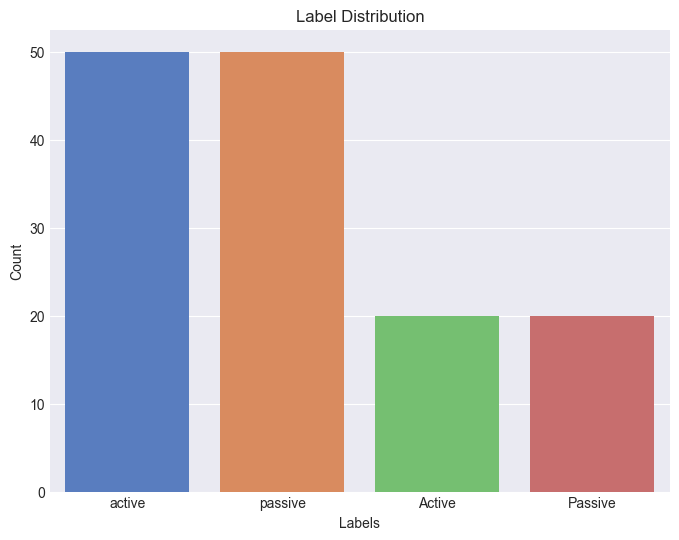

In [264]:

plt.figure(figsize=(8, 6))
sns.countplot(data=df, x='Labels')
plt.title("Label Distribution")
plt.xlabel("Labels")
plt.ylabel("Count")
plt.show()


In [265]:
#from the above Count plot we can see that :-
#labels are in different text format that's why it is showing 4, so we will convert it to lowercase format

## Converting "statement" and "label" to Lowercase

In [266]:
df['Statements'] = df['Statements'].apply(lambda x: x.lower())
df['Labels'] = df['Labels'].apply(lambda x: x.lower())

In [267]:
#now lets check the no unique values in Label column
df['Labels'].value_counts()

Labels
active     70
passive    70
Name: count, dtype: int64

## Checking for duplicate values in "Statement" Column

In [268]:
df['Statements'].duplicated().sum()

2

In [269]:
#There are 2 duplicate values, So lets remove those values
df.drop_duplicates(subset='Statements', keep='first', inplace=True)

## Visualizing the distribution of the Sentence lengths, No. of characters and No. of words in each Statement .

### 1.Sentence lengths

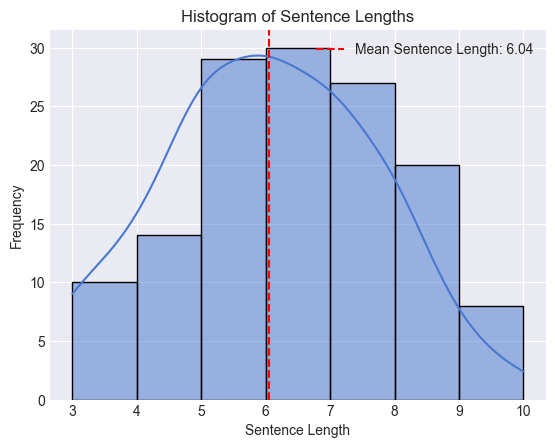

In [272]:

df['Sentence_len'] = df['Statements'].apply(lambda x: len(x.split()))

# Plot histogram with KDE curve
sns.histplot(data=df, x='Sentence_len', kde=True, bins=range(min(df['Sentence_len']), max(df['Sentence_len']) + 1, 1), edgecolor='black')
plt.xlabel('Sentence Length')
plt.ylabel('Frequency')
plt.title('Histogram of Sentence Lengths')

# Add a vertical line for the mean sentence length
mean_sentence_length = df['Sentence_len'].mean()
plt.axvline(mean_sentence_length, color='r', linestyle='--', label=f'Mean Sentence Length: {mean_sentence_length:.2f}')
plt.legend()

plt.show()

### 2.No. of characters

In [273]:
df['num_of_char']=df['Statements'].apply(len)


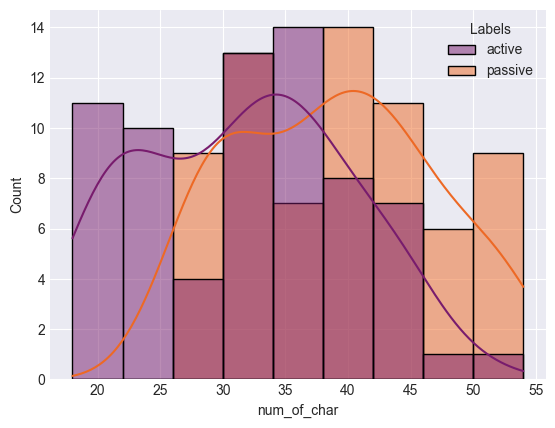

In [274]:
sns.histplot(data=df,x='num_of_char',hue="Labels",palette="inferno",kde=True); 

### 3. No. of words

In [275]:
df['num_of_words']=df['Statements'].apply(lambda x: len(nltk.word_tokenize(x)))


<Axes: xlabel='num_of_words', ylabel='Count'>

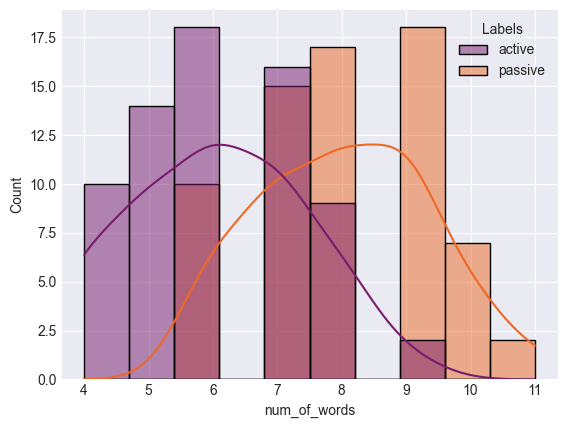

In [276]:
sns.histplot(data = df,hue="Labels",x='num_of_words',palette="inferno", kde=True)


## Preprocessing

### Function to preprocess text

In [277]:
#This function tokenizes,lemmatizes each token and then joins the lemmatized tokens back into a single string.
def preprocess_text(text):
    return " ".join([token.lemma_ for token in nlp(text)])

In [278]:
df['processed_sentence'] = df['Statements'].apply(preprocess_text)

### Removing Puctuations from the Statement (  '!"#%&\'()*+,-./:;<=>?@[\\]^_{|}~' )

In [279]:
# Load and preprocess the dataset
df['Statements'] = df['Statements'].apply(lambda x: "".join(i for i in x if i not in string.punctuation))


### Converting the "Labels" column into binary values(0,1)

In [280]:
lb = LabelEncoder()
df['Labels'] = lb.fit_transform(df['Labels'])


### Spliting the dataset into train, validation, and test sets (60:20:20)

In [281]:

X_train_val, X_test, y_train_val, y_test = train_test_split(df['processed_sentence'], df['Labels'], test_size=0.2, random_state=42)

X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25, random_state=42)  # 0.25 x 0.8 = 0.2


### Extracting TF-IDF features

In [282]:

tfidf_vectorizer = TfidfVectorizer()
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_val_tfidf = tfidf_vectorizer.transform(X_val)
X_test_tfidf = tfidf_vectorizer.transform(X_test)


## Training the Classification Models

In [283]:

models = {
    'Logistic Regression': LogisticRegression(),
    'Support Vector Machine': SVC(),
    'Random Forest': RandomForestClassifier(),
    'XGBoost': XGBClassifier()
}
validation_accuracies = []

In [284]:
for name, model in models.items():
    model.fit(X_train_tfidf, y_train)
    y_pred = model.predict(X_val_tfidf)
    validation_accuracy = accuracy_score(y_val, y_pred)
    validation_accuracies.append(validation_accuracy)

    print(f'{name} - Validation Accuracy: {validation_accuracy}')
    print("")
    print(f'{name} - Validation Classification Report:\n{classification_report(y_val, y_pred)}')
    print("="*100)

Logistic Regression - Validation Accuracy: 1.0

Logistic Regression - Validation Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        13
           1       1.00      1.00      1.00        15

    accuracy                           1.00        28
   macro avg       1.00      1.00      1.00        28
weighted avg       1.00      1.00      1.00        28

Support Vector Machine - Validation Accuracy: 0.5357142857142857

Support Vector Machine - Validation Classification Report:
              precision    recall  f1-score   support

           0       0.50      0.38      0.43        13
           1       0.56      0.67      0.61        15

    accuracy                           0.54        28
   macro avg       0.53      0.53      0.52        28
weighted avg       0.53      0.54      0.53        28

Random Forest - Validation Accuracy: 1.0

Random Forest - Validation Classification Report:
              precision  

## Visualizing the Validation Accuracy of Different Models

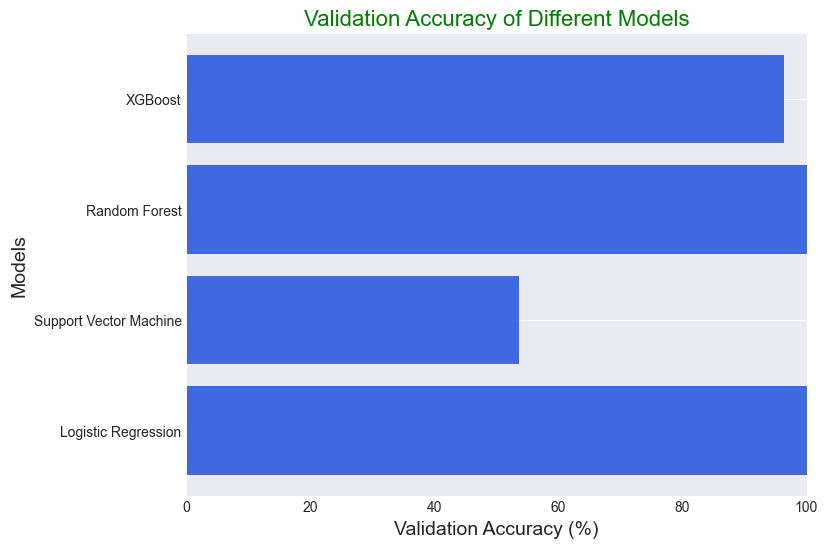

In [285]:
# Convert validation accuracies to percentage format
validation_accuracies_percentage = [acc * 100 for acc in validation_accuracies]

plt.figure(figsize=(8,6))
plt.barh(list(models.keys()), validation_accuracies_percentage, color='royalblue')  
plt.ylabel('Models', fontsize=14)
plt.xlabel('Validation Accuracy (%)', fontsize=14)
plt.title('Validation Accuracy of Different Models',color='green', fontsize=16)
plt.xlim(0, 100)  # Set x-axis limit from 0 to 100
plt.grid(axis='x')  # Add gridlines to the x-axis for better readability
plt.show()


## Choosing the best model based on validation accuracy

In [286]:

best_model_name = max(models, key=lambda x: accuracy_score(y_val, models[x].predict(X_val_tfidf)))
best_model = models[best_model_name]
print(f'Best Model: {best_model_name}')


Best Model: Logistic Regression


## Evaluating the best model on test set

In [287]:
y_pred_test = best_model.predict(X_test_tfidf)
print(f'{best_model_name} - Test Accuracy: {accuracy_score(y_test, y_pred_test)}')
print("-"*100)
print(f'{best_model_name} - Test Classification Report:\n{classification_report(y_test, y_pred_test)}')


Logistic Regression - Test Accuracy: 0.9642857142857143
----------------------------------------------------------------------------------------------------
Logistic Regression - Test Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.94      0.97        17
           1       0.92      1.00      0.96        11

    accuracy                           0.96        28
   macro avg       0.96      0.97      0.96        28
weighted avg       0.97      0.96      0.96        28



In [288]:
#The logistic Regression Model is giving 96% acccuracy on test set

In [289]:
#Lets see how Random Forest model works on test set
Random_forest=models['Random Forest']
y_pred_test = Random_forest.predict(X_test_tfidf)
print(f'{Random_forest} - Test Accuracy: {accuracy_score(y_test, y_pred_test)}')
print("-"*100)
print(f'{Random_forest} - Test Classification Report:\n{classification_report(y_test, y_pred_test)}')


RandomForestClassifier() - Test Accuracy: 1.0
----------------------------------------------------------------------------------------------------
RandomForestClassifier() - Test Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        17
           1       1.00      1.00      1.00        11

    accuracy                           1.00        28
   macro avg       1.00      1.00      1.00        28
weighted avg       1.00      1.00      1.00        28



In [290]:
#we can see that the Random_forest is giving 100% accuracy
best_model=Random_forest

## Confusion matrix

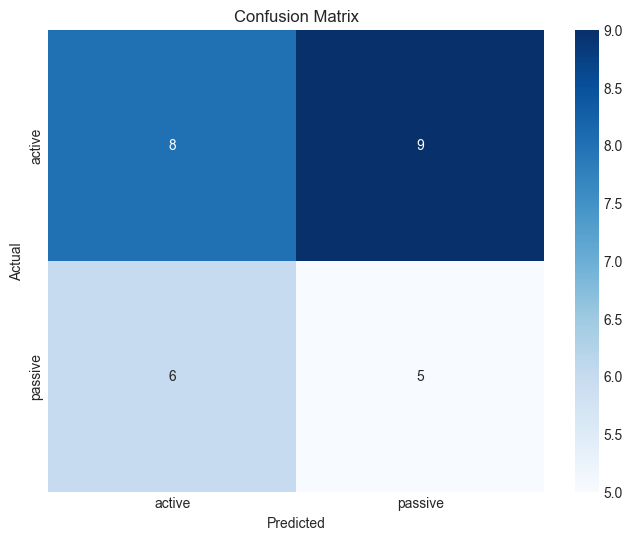

In [291]:

import matplotlib.pyplot as plt

# Define the labels dictionary
labels = {0: 'active', 1: 'passive'}

# Generate confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=labels.values(), yticklabels=labels.values())
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


In [292]:
import pickle

In [294]:
pickle.dump(best_model,open('Active_Passive.pkl','wb'))

In [295]:
pickle.dump(tfidf_vectorizer,open('tfidf_vectorizer.pkl', 'wb'))